## Dependencies

In [1]:
import glob
import warnings
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, SpatialDropout1D, Concatenate
from googleqa_utilityscript import *
from googleqa_map_utilityscript import *
from script_lr_schedulers import WarmUpLearningRateScheduler
import bert_tokenization as tokenization
from transformers import BertConfig, BertTokenizer, TFBertModel


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
BERT_PATH = '/kaggle/input/bert-base-uncased-huggingface-transformer/bert-base-uncased-tf_model.h5'
VOCAB_PATH = '/kaggle/input/bert-base-uncased-huggingface-transformer/bert-base-uncased-vocab.txt'

k_fold = pd.read_csv('/kaggle/input/googleqa-mldataset/5-fold.csv')
N_FOLDS = 3

print('Samples: %s' % len(k_fold))
display(k_fold.head())

Samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

# Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

# for feature in text_features:
#     # Lower
#     k_fold[feature] = k_fold[feature].apply(lambda x: x.lower())
#     # Map misspellings
#     k_fold[feature] = k_fold[feature].apply(lambda x: map_misspellings(x))
#     # Map contractions
#     k_fold[feature] = k_fold[feature].apply(lambda x: map_contraction(x))
#     # Trim text
#     k_fold[feature] = k_fold[feature].apply(lambda x: x.strip())

# Model parameters

In [5]:
EPOCHS = 8
BATCH_SIZE = 8
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
ES_PATIENCE = 1
MAX_SEQUENCE_LENGTH = 512
LR_WARMUP_EPOCHS = 2

# Model

In [6]:
bert_config = BertConfig()
bert_config.output_hidden_states=True

def model_fn():
    input_word_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    segment_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids')

    bert_model = TFBertModel.from_pretrained(BERT_PATH, config=bert_config)
    sequence_output, pooled_output, hidden_states = bert_model([input_word_ids, input_masks, segment_ids])
    
#     h12 = tf.reshape(hidden_states[-1][:,0],(-1,1,768))
#     h11 = tf.reshape(hidden_states[-2][:,0],(-1,1,768))
    h10 = tf.reshape(hidden_states[-3][:,0],(-1,1,768))
#     h09 = tf.reshape(hidden_states[-4][:,0],(-1,1,768))

    x = GlobalAveragePooling1D()(h10)
    x = Dropout(0.2)(x)
    output = Dense(N_CLASS, activation="sigmoid", name="output")(x)

    model = Model(inputs=[input_word_ids, input_masks, segment_ids], outputs=output)
    
    return model

# Train model

In [7]:
tokenizer = BertTokenizer.from_pretrained(VOCAB_PATH, do_lower_case=True)

history_list = []
metric_list = []
category_metric_list = []
target_cols_preds = [col+'_pred' for col in target_cols]

for n_fold in range(N_FOLDS):
    ### Data
    train = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation']
    
    ### Create features
    # Train features
    X_train = compute_input_arays(train, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
    Y_train = train[target_cols].values

    # Validation features
    X_valid = compute_input_arays(validation, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
    Y_valid = validation[target_cols].values

    # Train model
    model_path = '/kaggle/working/model_fold_%d' % (n_fold+1)
    spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                           validation_data=(X_valid, Y_valid), 
                                           model_path=model_path, 
                                           monitor='val_loss', mode='min', 
                                           patience=ES_PATIENCE, checkpoint=True)
    WARMUP_BATCHES = LR_WARMUP_EPOCHS * len(train) // BATCH_SIZE
    warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

    callback_list = [spearmanCallback, warmup_lr]
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model = model_fn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid), 
                        callbacks=callback_list, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights('/kaggle/working/model_fold_%d_last_epoch.h5' % (n_fold+1))
    
    ### Evaluation - Label metrics
    model.load_weights(model_path+'.h5')
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_valid)
    metric_list.append(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))
    
    ### Evaluation - Category metrics
    for col in target_cols_preds:
        train[col] = 0
        validation[col] = 0

    train[target_cols_preds] = preds_train
    validation[target_cols_preds] = preds_val
    category_metric_list.append(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

Train on 4864 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.2898 val_spearman-rho: 0.2753
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 418s - loss: 0.4764 - val_loss: 0.3967
Epoch 2/8
spearman-rho: 0.3955 val_spearman-rho: 0.3604
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 399s - loss: 0.3955 - val_loss: 0.3749
Epoch 3/8
spearman-rho: 0.4566 val_spearman-rho: 0.3848
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 399s - loss: 0.3746 - val_loss: 0.3675
Epoch 4/8
spearman-rho: 0.5022 val_spearman-rho: 0.3965
Epoch 00003: early stopping
4864/4864 - 397s - loss: 0.3601 - val_loss: 0.3684
Train on 4864 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.3110 val_spearman-rho: 0.2877
Saved model weights at "/kaggle/working/model_fold_2.h5"
4864/4864 - 417s - loss: 0.4765 - val_loss: 0.3959
Epoch 2/8
spearman-rho: 0.4018 val_spearman-rho: 0.3580
Saved model weights at "/kaggle/working/model_fold_2.h5"


## Model loss graph

Fold: 0


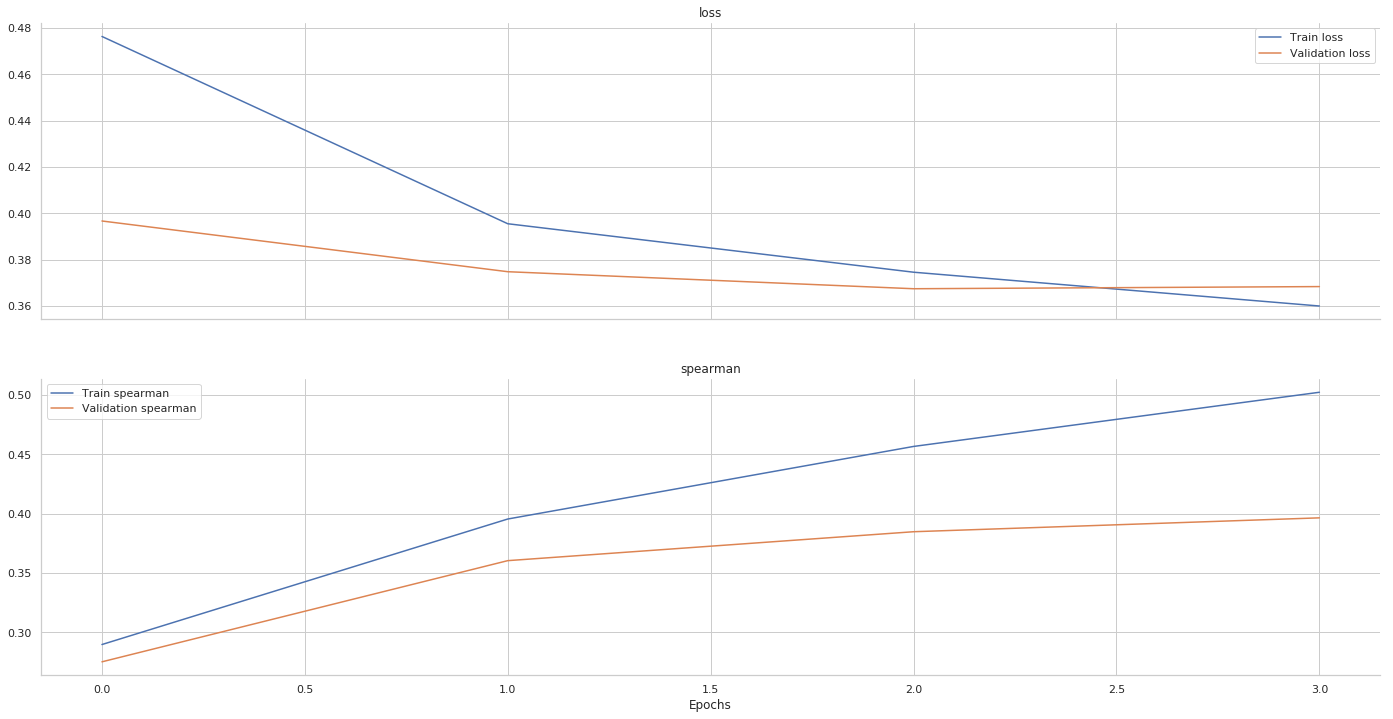

Fold: 1


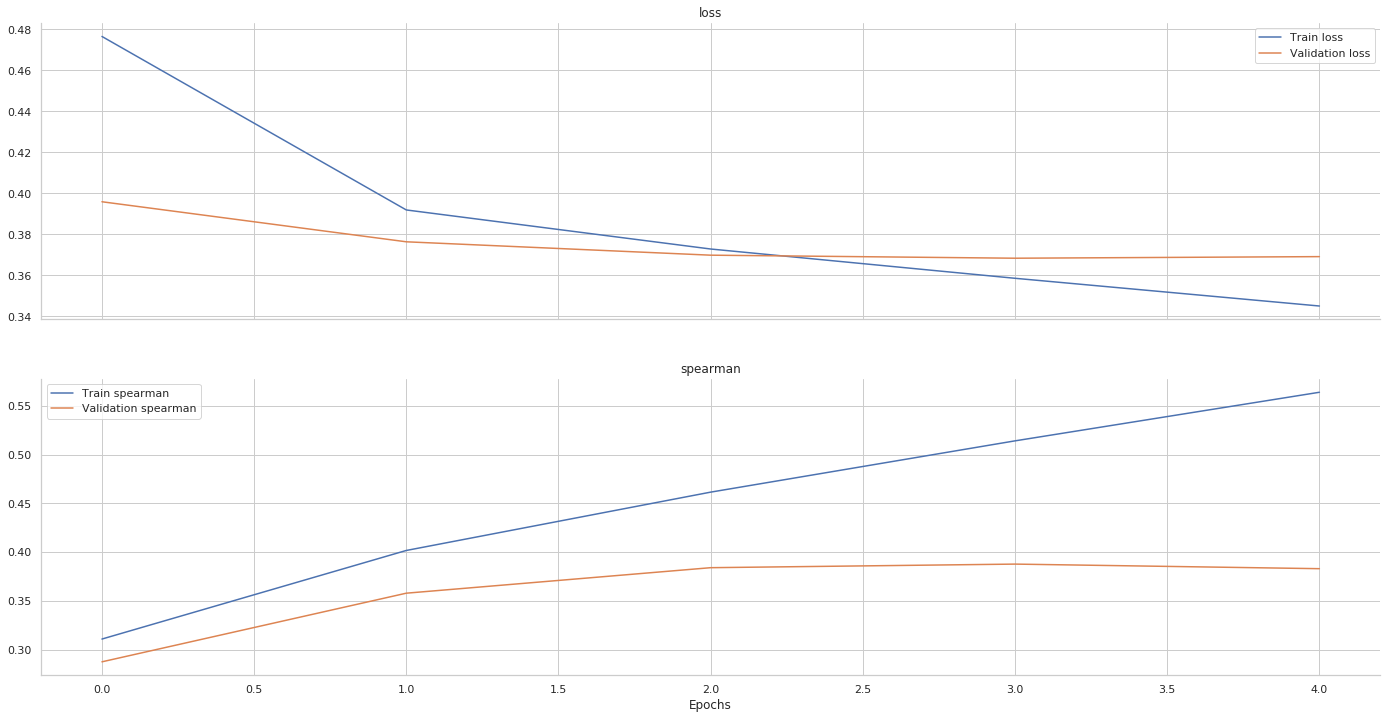

Fold: 2


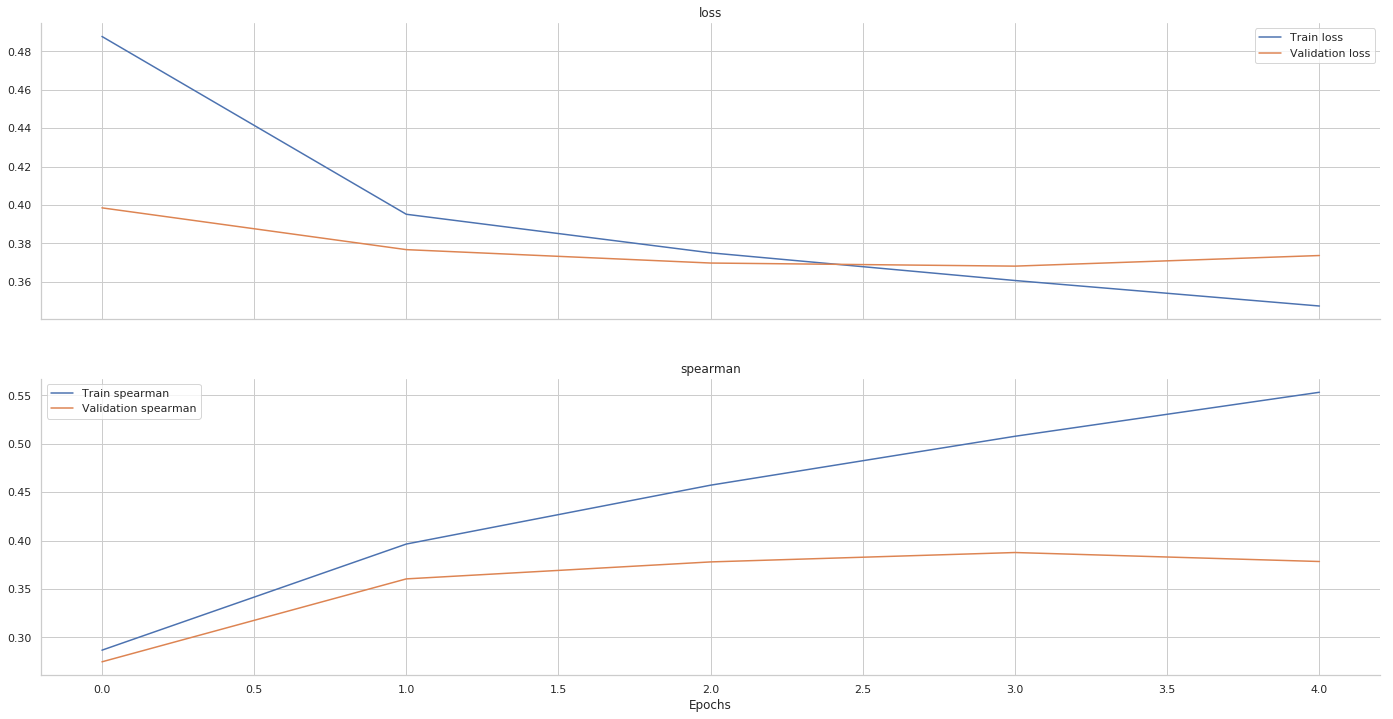

In [8]:
for n_fold in range(N_FOLDS):
    print('Fold: %d' % n_fold)
    sns.set(style="whitegrid")
    plot_metrics(history_list[n_fold], metric_list=['loss', 'spearman'])

# Evaluation

In [9]:
metrics_df = metric_list[0][['Label', 'Train', 'Validation']].copy()
metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    metrics_df_idx = metric_list[n_fold][['Train', 'Validation']].copy()
    metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    metrics_df = pd.concat([metrics_df, metrics_df_idx], axis=1)

metrics_df['Train'] = 0
metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    metrics_df['Train'] += metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    metrics_df['Validation'] += metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS

metrics_df['Var'] = metrics_df['Train'] - metrics_df['Validation']
display(metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,Averaged,0.457,0.385,0.514,0.388,0.508,0.388,0.493,0.387,0.106
1,Question averaged,0.478,0.415,0.525,0.415,0.521,0.407,0.508,0.412333,0.0956667
2,Answer averaged,0.406,0.315,0.488,0.323,0.477,0.342,0.457,0.326667,0.130333
3,question_asker_intent_understanding,0.409,0.332,0.47,0.363,0.471,0.3,0.45,0.331667,0.118333
4,question_body_critical,0.656,0.573,0.692,0.65,0.682,0.577,0.676667,0.6,0.0766667
5,question_conversational,0.449,0.423,0.473,0.393,0.47,0.411,0.464,0.409,0.055
6,question_expect_short_answer,0.434,0.333,0.544,0.263,0.538,0.257,0.505333,0.284333,0.221
7,question_fact_seeking,0.483,0.392,0.586,0.337,0.575,0.384,0.548,0.371,0.177
8,question_has_commonly_accepted_answer,0.533,0.446,0.608,0.445,0.619,0.395,0.586667,0.428667,0.158
9,question_interestingness_others,0.387,0.328,0.42,0.323,0.42,0.309,0.409,0.32,0.089


## By category

In [10]:
category_metrics_df = category_metric_list[0][['Label', 'Train', 'Validation']].copy()
category_metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    category_metrics_df_idx = category_metric_list[n_fold][['Train', 'Validation']].copy()
    category_metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    category_metrics_df = pd.concat([category_metrics_df, category_metrics_df_idx], axis=1)
    
category_metrics_df['Train'] = 0
category_metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    category_metrics_df['Train'] += category_metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    category_metrics_df['Validation'] += category_metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS
    
category_metrics_df['Var'] = category_metrics_df['Train'] - category_metrics_df['Validation']
display(category_metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,LIFE_ARTS,0.487,0.417,0.56,0.419,0.538,0.429,0.528333,0.421667,0.106667
1,SCIENCE,0.471,0.394,0.559,0.35,0.544,0.399,0.524667,0.381,0.143667
2,CULTURE,0.491,0.403,0.538,0.386,0.474,0.342,0.501,0.377,0.124
3,STACKOVERFLOW,0.329,0.256,0.398,0.272,0.528,0.393,0.418333,0.307,0.111333
4,TECHNOLOGY,0.417,0.336,0.478,0.36,0.404,0.252,0.433,0.316,0.117
